# Inventory management project

## Data exploration and preparation

### Data loading

In [83]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [84]:
# load data

df_infos = pd.read_csv("infos.csv", sep = "|")
df_items = pd.read_csv("items.csv", sep = "|")
df_orders_orig = pd.read_csv("orders.csv.zip", sep = "|", compression="zip")

### Train and Test split

In [85]:
# fix datetime format for transaction time

df_orders_orig['time'] = pd.to_datetime(df_orders_orig['time'])

In [86]:
len(df_orders_orig["itemID"].unique())

9840

In [87]:
# Define the split date
split_date = pd.to_datetime("08.06.2018", format="%d.%m.%Y")

# Split into train and test
df_test = df_orders_orig[df_orders_orig['time'] > split_date]
df_orders = df_orders_orig[df_orders_orig['time'] <= split_date]

In [88]:
# we saw that we lose around 1000 items with the train-test split, because they have orders only in the last 3 weeks
# so we check their price x quantity (revenue) - what % it is of the total revenue
# to see if we lose a lot with this cropping and decide how to continue

In [89]:
df_test["revenue"] = df_test["order"] * df_test["salesPrice"]
df_orders_orig["revenue"] = df_orders_orig["order"] * df_orders_orig["salesPrice"]

C:\Users\Konstantin Piryankov\AppData\Local\Temp\ipykernel_21684\2036663582.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test["revenue"] = df_test["order"] * df_test["salesPrice"]


In [90]:
missing_items = pd.DataFrame(df_test[~df_test["itemID"].isin(df_orders["itemID"])]["itemID"].unique(), columns = ["itemID"])
missing_items["will_be_lost"] = "yes"

In [91]:
df_orders_orig = df_orders_orig.merge(missing_items, how = "left", on = "itemID")

In [92]:
df_orders_orig["revenue"] = df_orders_orig["salesPrice"] * df_orders_orig["order"]

In [93]:
round((df_orders_orig[df_orders_orig["will_be_lost"] == "yes"]["revenue"].sum()/df_orders_orig["revenue"].sum())*100, 2)

5.09

In [94]:
# they account for 5.09% of the total revenue of the historical 6-month data we have
# it is low enough, we continue like this

### df_orders preparation

In [95]:
df_orders.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1822740 entries, 0 to 1822739
Data columns (total 5 columns):
 #   Column      Dtype         
---  ------      -----         
 0   time        datetime64[ns]
 1   transactID  int64         
 2   itemID      int64         
 3   order       int64         
 4   salesPrice  float64       
dtypes: datetime64[ns](1), float64(1), int64(3)
memory usage: 83.4 MB


In [96]:
# add one column which is only with the date, no time

df_orders['date'] = df_orders['time'].dt.date
df_orders['date'] = pd.to_datetime(df_orders['date'])

In [97]:
# there seem to be 0 price transactions

len(df_orders[df_orders["salesPrice"]==0])/len(df_orders)*100

# they are 0.02% of all transactions, it is best to delete them instead of thinking how to handle them

df_orders = df_orders[df_orders["salesPrice"]!=0]

In [98]:
# do all items have an order in the period we have?

round(df_orders["itemID"].nunique()/len(df_items)*100, 2)

# 94.05% of all items have an order in the period

83.47

In [99]:
# which transactions are performed on a discounted price?
# we assume the following: a transaction is marked as having a promotion if, for the same item, somewhere else in the table there is
# another transaction performed on a lower price

# Step 1: Get the maximum price per itemID
max_price_per_item = df_orders.groupby('itemID')['salesPrice'].transform('max')

# Step 2: Compare each row's price to the max price for that item
df_orders['promotion'] = df_orders['salesPrice'] < max_price_per_item

# Step 3: Convert boolean to "yes"/"no"
df_orders['promotion'] = df_orders['promotion'].map({True: 1, False: 0})

In [100]:
# this data frame will be aggregared on day level for final use
# so it is best if we continue the transformation in the aggregated version
# but before aggregation, we should check what % of items have been sold on a different price in the same day

price_variations = (
    df_orders
    .assign(date=df_orders['time'].dt.date)
    .groupby(['itemID', 'date'])['salesPrice']
    .nunique()
    .reset_index(name='unique_price_count')
)


# Filter where price count > 1 (i.e., same item sold at multiple prices)
price_variations[price_variations['unique_price_count'] > 1]

,itemID,date,unique_price_count
72,6,2018-05-30,2
163,15,2018-01-27,2
337,27,2018-02-17,2
422,34,2018-05-03,2
471,35,2018-05-25,4
...,...,...,...
82205,10237,2018-05-24,2
82266,10286,2018-05-19,2
82269,10287,2018-05-24,2
82287,10296,2018-05-24,2


In [101]:
# % of such cases from all items

((price_variations[price_variations['unique_price_count'] > 1]['unique_price_count'].count())/len(df_items))*100

9.481028385740228

### df_infos preparation

#### Preparation

In [102]:
# in df_infos column promotion there are cells with more than one date, separated by a comma
# how many such are there?

(df_infos["promotion"].str.len() > 10).sum()

# 190
# I leave it as text for now, we should handle it later

190

In [103]:
df_infos["promotion"][df_infos["promotion"].str.len() > 10]

34       2018-07-01,2018-07-02,2018-07-13
74                  2018-07-05,2018-07-11
124                 2018-07-08,2018-07-13
125                 2018-07-05,2018-07-11
353                 2018-07-08,2018-07-11
                       ...               
9996                2018-07-02,2018-07-05
10093               2018-07-05,2018-07-09
10111    2018-07-04,2018-07-05,2018-07-06
10176               2018-07-01,2018-07-10
10318               2018-07-05,2018-07-06
Name: promotion, Length: 190, dtype: object

In [104]:
# does df_infos, containing the promotions, contain unique item IDs or are they duplicated?
# I expect them to be unique

len(df_infos["itemID"]) == len(df_items)
df_infos["itemID"].value_counts().max() == 1


True

In [105]:
df_infos["itemID"].isin(df_items["itemID"]).count() == len(df_infos["itemID"])

# it contains a row for each itemID

True

#### Deriving discounts for the simulation period

In [106]:
df_orders["maxPrice"] = df_orders.groupby("itemID")["salesPrice"].transform("max")

In [107]:
# how do discounts vary

df_orders["discountAmount"] = round(df_orders["maxPrice"] - df_orders["salesPrice"], 2)

df_orders["discountPerc"] = round(df_orders["discountAmount"]/df_orders["maxPrice"], 2)

In [108]:
# max and min % discount

print(max(df_orders["discountPerc"]), min(df_orders["discountPerc"][df_orders["discountPerc"] != 0]))

0.95 0.01


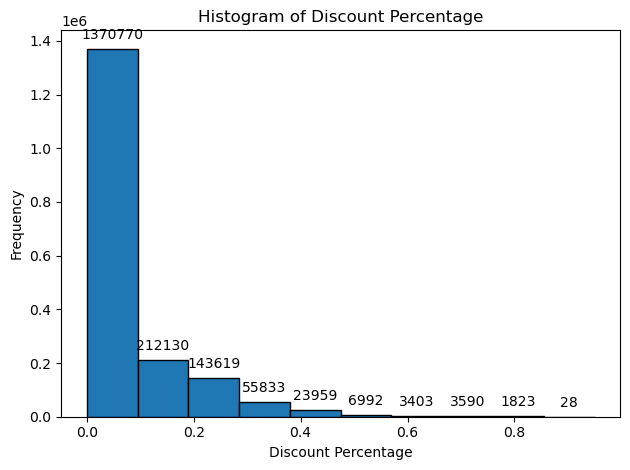

In [109]:
# Create the histogram and get the bars
ax = df_orders["discountPerc"].plot(kind="hist", bins=10, edgecolor='black')

# Add value labels on top of each bar
for patch in ax.patches:
    height = patch.get_height()
    if height > 0:
        ax.annotate(f'{int(height)}', 
                    xy=(patch.get_x() + patch.get_width() / 2, height), 
                    xytext=(0, 5),  # offset
                    textcoords="offset points",
                    ha='center', va='bottom')

plt.xlabel("Discount Percentage")
plt.ylabel("Frequency")
plt.title("Histogram of Discount Percentage")
plt.tight_layout()
plt.show()

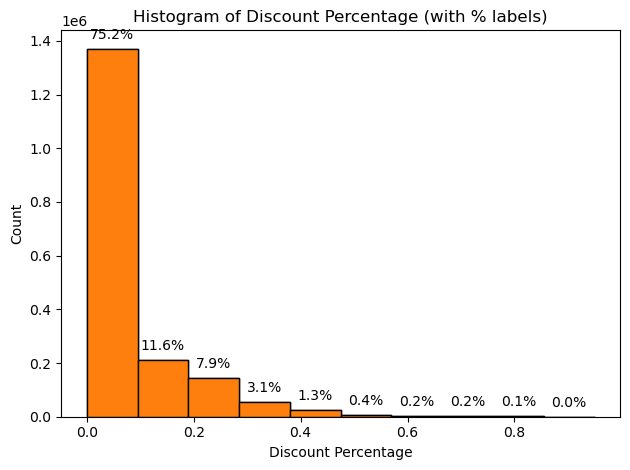

In [110]:
# Total number of observations
total = len(df_orders["discountPerc"].dropna())

# Plot the histogram as density (normalized)
ax = df_orders["discountPerc"].plot(kind="hist", bins=10, edgecolor='black', density=False)

# Get the actual bin heights (counts) to calculate percentages
counts, bins, patches = plt.hist(df_orders["discountPerc"].dropna(), bins=10, edgecolor='black')

# Annotate bars with percentage labels
for count, patch in zip(counts, patches):
    percentage = 100 * count / total
    if count > 0:
        plt.annotate(f'{percentage:.1f}%', 
                     xy=(patch.get_x() + patch.get_width() / 2, count), 
                     xytext=(0, 5),
                     textcoords="offset points",
                     ha='center', va='bottom')

plt.xlabel("Discount Percentage")
plt.ylabel("Count")
plt.title("Histogram of Discount Percentage (with % labels)")
plt.tight_layout()
plt.show()

In [111]:
# looking at the skewed distribution, for getting an approximate discount percentage per item
# it would be better to use the median instead of the mean
# adding column for discounted price to table df_infos = simulation price - median discount for item
# Start with itemID column
df_discount_stats = df_items[["itemID"]].copy()

# Filter out rows where discountAmount is 0
df_nonzero_discounts = df_orders[df_orders["discountAmount"] != 0].copy()

# Drop duplicates to keep only unique discount percentages per item
unique_discounts = df_nonzero_discounts.drop_duplicates(subset=["itemID", "discountPerc"])

# Now compute the median of these unique values per item
median_discounts = (
    unique_discounts
    .groupby("itemID")["discountPerc"]
    .median()
    .round(2)
    .reset_index()
    .rename(columns={"discountPerc": "medianDiscPerc"})
)

# Merge into df_discount_stats
df_discount_stats = df_discount_stats.merge(median_discounts, on="itemID", how="left")



In [112]:
# adding column for discounted price to table df_infos = simulation price - median discount for item

df_infos = df_infos.merge(df_discount_stats[['itemID', 'medianDiscPerc']], on='itemID', how='left')

In [113]:
# adding column for discounted price to table df_infos = simulation price - median discount for item

df_infos["discountedPrice"] = np.where(
    df_infos["promotion"].notna(),
    round(df_infos["simulationPrice"] * (1 - df_infos["medianDiscPerc"]), 2),
    np.nan  # or just leave it to default if you prefer
)


In [114]:
# unfinished - we have to use some mean based on similar items to derive median discount % for items which will have
# a promotion in the simulation period but have not had a discount in the historical data

In [115]:
# adding also min price per item in the orders data frame for completion

df_orders["minPrice"] = df_orders.groupby("itemID")["salesPrice"].transform("min")

#### Quickly check relation - qty sold and promotion

In [116]:
# promo tests

# Step 1: Sum quantity per itemID, date, and promotion (daily sales)
daily_qty = (
    df_orders
    .groupby(['itemID', 'date', 'promotion'])['order']
    .sum()
    .reset_index()
)

# Step 2: Aggregate by itemID and promotion: 
# total quantity sold (sum of daily sums)
# count of days with sales (number of unique days)
agg = daily_qty.groupby(['itemID', 'promotion']).agg(
    total_qty=('order', 'sum'),
    count_days=('date', 'nunique')
).unstack(fill_value=0)

# Step 3: Build the final DataFrame safely extracting promo/no promo columns
summary = pd.DataFrame({
    'QTY_no_promo': agg['total_qty'].get(0, pd.Series(0)),
    'QTY_promo': agg['total_qty'].get(1, pd.Series(0)),
    'count_days_no_promo': agg['count_days'].get(0, pd.Series(0)),
    'count_days_promo': agg['count_days'].get(1, pd.Series(0))
}).reset_index()

# Step 4: Calculate average quantity per day (handle division by zero)
summary['QTY_no_promo_per_day'] = summary.apply(
    lambda r: r['QTY_no_promo'] / r['count_days_no_promo'] if r['count_days_no_promo'] > 0 else 0,
    axis=1
)
summary['QTY_promo_per_day'] = summary.apply(
    lambda r: r['QTY_promo'] / r['count_days_promo'] if r['count_days_promo'] > 0 else 0,
    axis=1
)


In [117]:
# promo tests

len(summary[summary["QTY_promo_per_day"] > summary["QTY_no_promo_per_day"]])/len(summary)

0.1913431810374442

## Aggregate orders

In [118]:
# aggregate df_orders on a daily basis
# sum of QTY
# average of price (or median?)?
# promotion - if 1 is present, then 1 (had at least 1 promotion in that day)
# median discount %?
# median discount amount?

# to make a desicion wether to use mean of median for price, discount amount, discount perc
# we have to look at the distribution of the prices for some items


### Checking price per item distributions

In [119]:
# adding a column with item_prices_count to df_orders

df_orders["item_prices_count"] = df_orders.groupby("itemID")["salesPrice"].transform(lambda x: x.nunique())

In [120]:
# getting a random sample where the item has price discount of > 0.79, meaning there might
# be great price variations of the item

df_sample = df_orders[["itemID"]][df_orders["discountPerc"] > 0.79]

df_sample = df_sample.sample(n=50, random_state=222)

df_sample = df_sample.sort_values(by="itemID", ascending=True)

df_sample = df_sample.merge(df_orders, how="left", on="itemID")

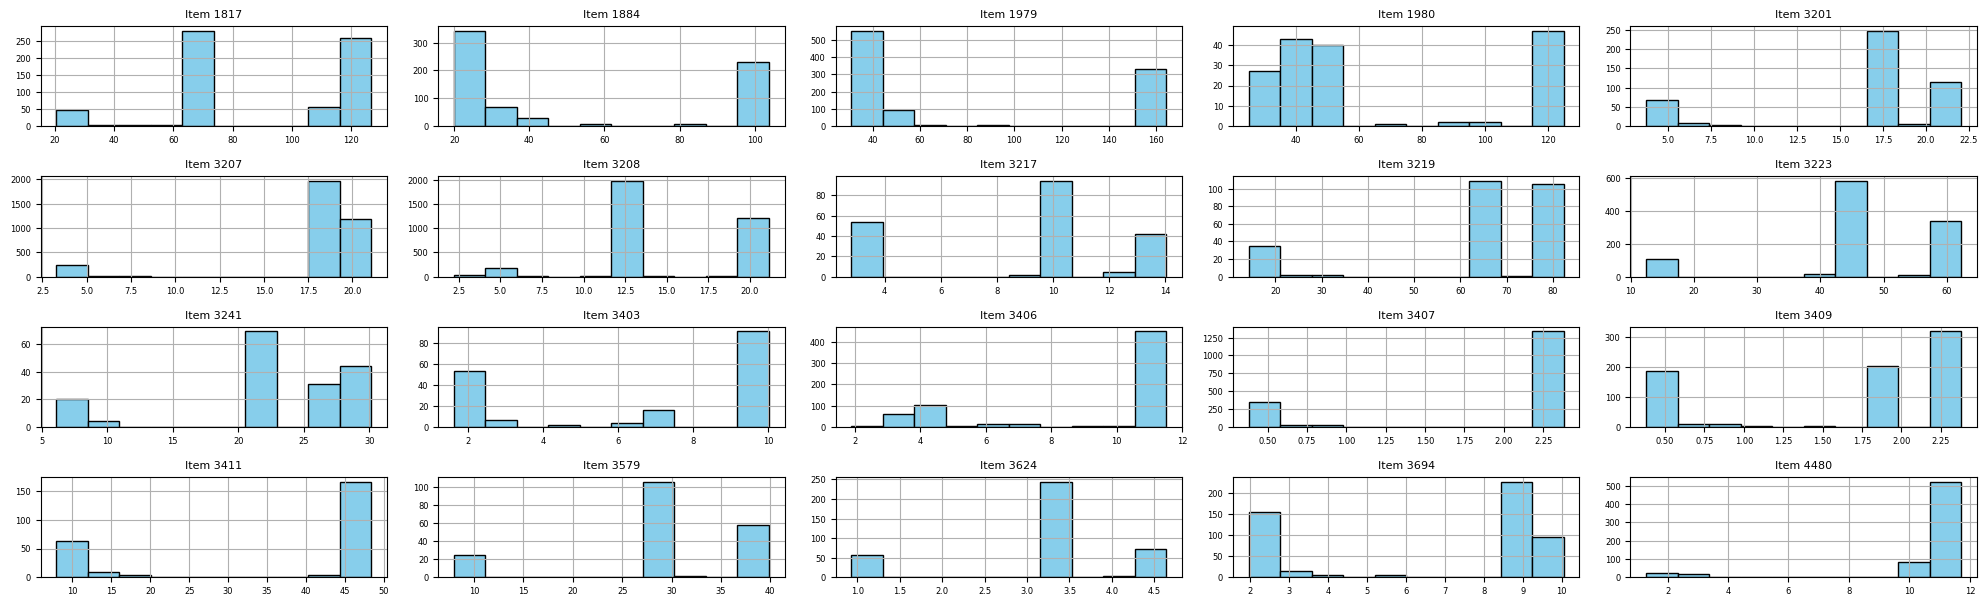

In [121]:
# visualizing 

# Unique items
item_ids = df_sample['itemID'].unique()

# Set up the grid
rows, cols = 10, 5
fig, axes = plt.subplots(rows, cols, figsize=(20, 15), sharex=False, sharey=False)
axes = axes.flatten()

# Plot histogram for each item
for i, item_id in enumerate(item_ids):
    ax = axes[i]
    item_prices = df_sample[df_sample['itemID'] == item_id]['salesPrice']

    ax.hist(item_prices, bins=10, color='skyblue', edgecolor='black')
    ax.set_title(f'Item {item_id}', fontsize=8)
    ax.tick_params(labelsize=6)
    ax.grid(True)

# Hide unused subplots
for j in range(len(item_ids), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [122]:
# it would be useful to see another check to make aa decision
# see the top 10 items for which the mean and median are the most different and
# see which one makes more sence for us

# Group by itemID and compute mean and median
price_stats = df_orders.groupby('itemID')['salesPrice'].agg(
    mean_price='mean',
    median_price='median'
).reset_index()

# Compute absolute difference
price_stats['abs_diff'] = (price_stats['mean_price'] - price_stats['median_price']).abs()

# Compute absolute percentage difference relative to median
price_stats['abs_perc_diff'] = (price_stats['abs_diff'] / price_stats['median_price']).abs() * 100

# Round numerical columns
price_stats[['mean_price', 'median_price', 'abs_diff', 'abs_perc_diff']] = price_stats[
    ['mean_price', 'median_price', 'abs_diff', 'abs_perc_diff']].round(2)

# Sort by absolute percentage difference descending
price_stats = price_stats.sort_values(by='abs_perc_diff', ascending=False)

In [123]:
# now look at histograms of top 50 of items with most % difference of mean and median

df_sample = price_stats.sort_values(by='abs_perc_diff', ascending=False).head(50)[["itemID"]]

df_sample = df_sample.sample(n=50, random_state=222)

df_sample = df_sample.sort_values(by="itemID", ascending=True)

df_sample = df_sample.merge(df_orders, how="left", on="itemID")

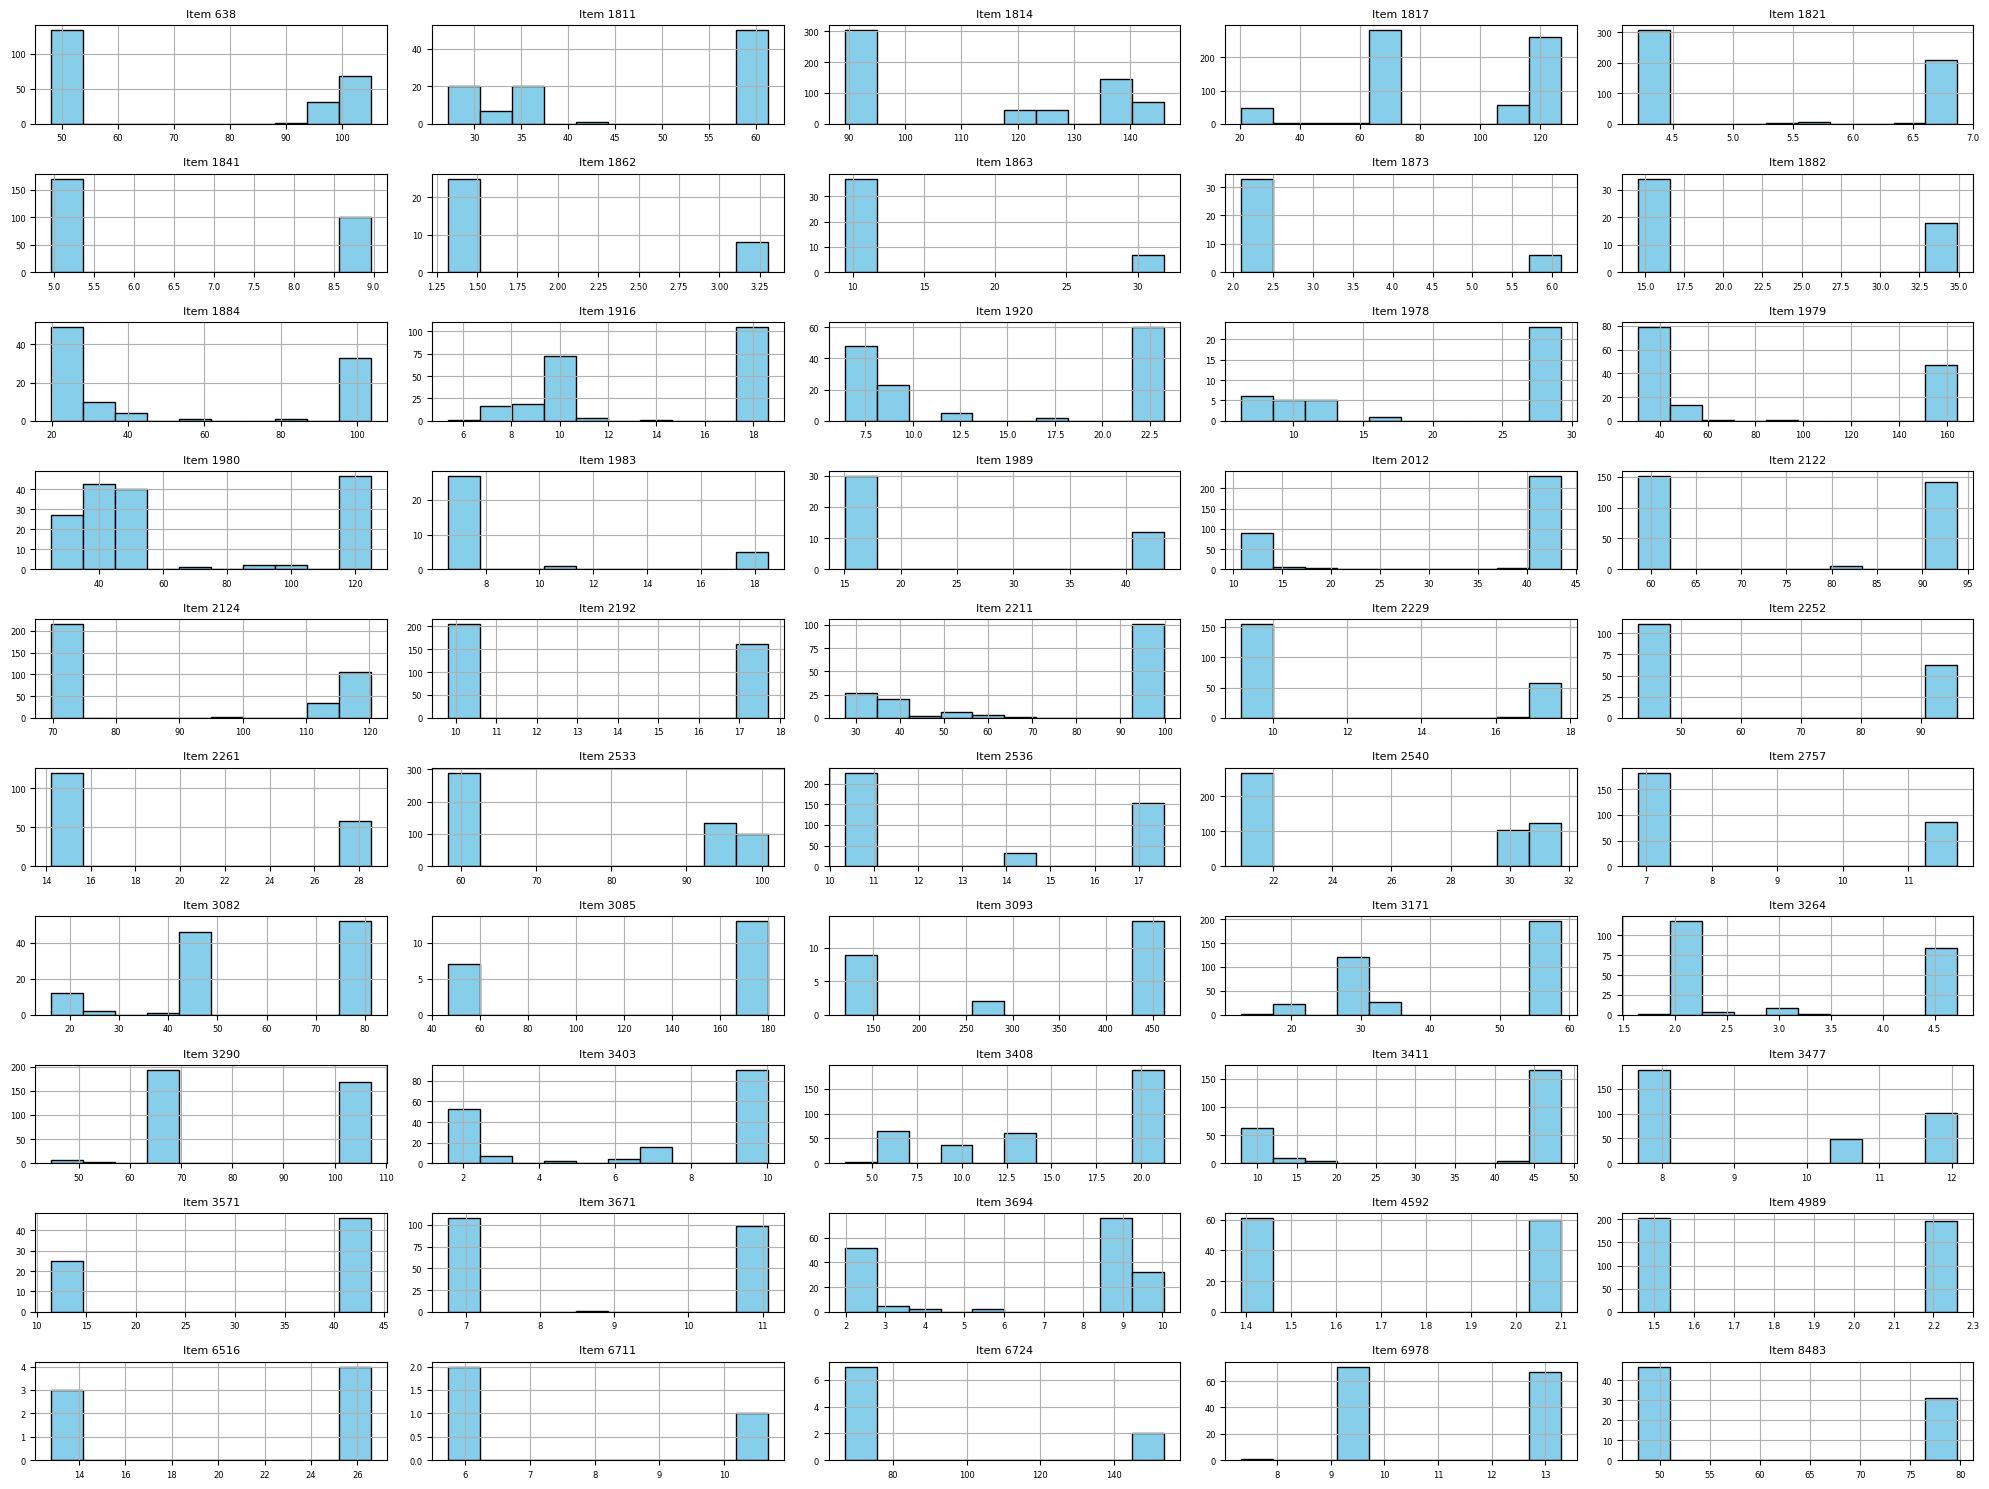

In [124]:
# visualizing 

# Unique items
item_ids = df_sample['itemID'].unique()

# Set up the grid
rows, cols = 10, 5
fig, axes = plt.subplots(rows, cols, figsize=(20, 15), sharex=False, sharey=False)
axes = axes.flatten()

# Plot histogram for each item
for i, item_id in enumerate(item_ids):
    ax = axes[i]
    item_prices = df_sample[df_sample['itemID'] == item_id]['salesPrice']

    ax.hist(item_prices, bins=10, color='skyblue', edgecolor='black')
    ax.set_title(f'Item {item_id}', fontsize=8)
    ax.tick_params(labelsize=6)
    ax.grid(True)

# Hide unused subplots
for j in range(len(item_ids), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [125]:
# it is better to use mean because the extreme values are not a one-case accidental thing

In [126]:
# aggregate using mean (average), but specifically weighted average, to gain price per each
# weighted average will take into account how accidental the outlier prices were

### Aggregate orders on day level

In [127]:
# in order to get weighted average price per each for the items
# first we need to add a column to df_orders
# with order value = qty * price

df_orders["orderValue"] = df_orders["order"] * df_orders["salesPrice"]

In [128]:
# aggregating on day level

df_orders_daily = df_orders.groupby(['date', 'itemID']).agg(
    qty_sold=('order', 'sum'),
    sales_value=('orderValue', 'sum'),
    promotion=('promotion', 'max'),  # If any transaction had promotion == 1, result will be 1
    maxItemPrice=('maxPrice', 'max'), # doesn't matter min or max - its the same value for all transactions with the same item
    minItemPrice=('minPrice', 'max') # doesn't matter min or max - its the same value for all transactions with the same item
).reset_index()

In [129]:
# deriving price per each for the items
# checkp change to last mode

df_orders_daily["TotalItemQty"] = df_orders_daily.groupby("itemID")["qty_sold"].transform("sum")
df_orders_daily["TotalItemValue"] = df_orders_daily.groupby("itemID")["sales_value"].transform("sum")

df_orders_daily["PricePerEach"] = round(df_orders_daily["TotalItemValue"] / df_orders_daily["TotalItemQty"], 2)

df_orders_daily = df_orders_daily.drop(['TotalItemQty', 'TotalItemValue'], axis=1)

In [130]:
# deriving price per each for the items, but specific price for that day

df_orders_daily["DailyItemQty"] = df_orders_daily.groupby(["itemID", "date"])["qty_sold"].transform("sum")
df_orders_daily["DailyItemValue"] = df_orders_daily.groupby(["itemID", "date"])["sales_value"].transform("sum")

df_orders_daily["PricePerEachToday"] = round(df_orders_daily["DailyItemValue"] / df_orders_daily["DailyItemQty"], 2)

df_orders_daily = df_orders_daily.drop(['DailyItemQty', 'DailyItemValue'], axis=1)

In [131]:
# add median discout for the items
# we have it currently for each item in df_infos

# Select only itemID and medianDiscount from df_infos and merge on itemID
df_orders_daily = df_orders_daily.merge(
    df_infos[["itemID", "medianDiscPerc"]],
    how="left",
    on="itemID"
)

## Add features

#### Complete main DF with missing date + item combinations

In [132]:
# completing our main data frame with all missing day+item combinations
# for them qty_sold = 0, sales_value = 0, promotion = 0, maxItemPrice = maxItemPrice, minItemPrice = minItemPrice
# PricePerEach = mean PricePerEach for that item, medianDiscPerc = medianDiscPerc

new_df = pd.DataFrame(df_orders_daily["itemID"].unique(), columns = ["itemID"])

In [133]:
# Create date range
date_range = pd.date_range(start='2018-01-01', end='2018-06-07', freq='D')

# Create DataFrame
df_dates = pd.DataFrame({'date': date_range})

In [134]:
# Add a dummy key to both DataFrames
df_dates["key"] = 1
new_df["key"] = 1

# Perform cross join
new_df = pd.merge(df_dates, new_df, on="key").drop("key", axis=1)

# Sort by date and then itemID
new_df = new_df.sort_values(by=["date", "itemID"]).reset_index(drop=True)


In [135]:
df_orders_daily = new_df.merge(df_orders_daily, how="left", on=["date", "itemID"])

In [136]:
# for them qty_sold = 0, sales_value = 0, promotion = 0

df_orders_daily[["qty_sold", "sales_value", "promotion"]] = df_orders_daily[["qty_sold", "sales_value", "promotion"]].fillna(0)

In [137]:
# maxItemPrice = maxItemPrice, minItemPrice = minItemPrice, PricePerEach = mean PricePerEach for that item, medianDiscPerc = medianDiscPerc

# Fill missing maxItemPrice with the max per itemID
df_orders_daily["maxItemPrice"] = df_orders_daily.groupby("itemID")["maxItemPrice"].transform(lambda x: x.fillna(x.max()))

# Fill missing minItemPrice with the max per itemID
df_orders_daily["minItemPrice"] = df_orders_daily.groupby("itemID")["minItemPrice"].transform(lambda x: x.fillna(x.max()))

# Fill missing PricePerEach with the max per itemID
df_orders_daily["PricePerEach"] = df_orders_daily.groupby("itemID")["PricePerEach"].transform(lambda x: x.fillna(x.max()))

# Fill missing PricePerEachToday with the mean per itemID
df_orders_daily["PricePerEachToday"] = df_orders_daily.groupby("itemID")["PricePerEachToday"].transform(lambda x: x.fillna(x.mean()))

df_orders_daily["PricePerEachToday"] = df_orders_daily["PricePerEachToday"].round(2)

# Fill missing medianDiscPerc with the max per itemID
df_orders_daily["medianDiscPerc"] = df_orders_daily.groupby("itemID")["medianDiscPerc"].transform(lambda x: x.fillna(x.max()))

#### Add masterdata

In [138]:
# include masterdata

df_orders_daily = df_orders_daily.merge(df_items, how="left", on="itemID")

#### Add date features

In [139]:
# Add date features
df_orders_daily["weekDay"] = df_orders_daily["date"].dt.weekday + 1
df_orders_daily["day"] = df_orders_daily["date"].dt.day

In [140]:
def get_week_of_month(date):
    # First day of the month
    first_day = date.replace(day=1)
    
    # Find the day of the week the first day lands on (Monday=0, Sunday=6)
    first_day_weekday = first_day.weekday()
    
    # Calendar row index = (day of month + offset from Monday) // 7 + 1
    return ((date.day + first_day_weekday - 1) // 7) + 1

# Apply the function to create the column
df_orders_daily['weekOfMonth'] = df_orders_daily['date'].apply(get_week_of_month)

#### Add lagged variables

In [141]:
# sort by item and date before shift
df_orders_daily = df_orders_daily.sort_values(by=["itemID", "date"])


In [142]:
# looking at average daily orders and median daily orders of the items
# to help decide how many lags are appropriate

# define a function to compute the median of unique values
def median_of_unique(x):
    return np.median(np.unique(x))

# compute average daily orders and median of unique daily orders
item_daily_stats = (
    df_orders_daily.groupby('itemID')["qty_sold"]
    .agg(
        avg_daily_orders='mean',
        median_daily_orders_unique=lambda x: median_of_unique(x)
    )
    .reset_index()
)

item_daily_stats["avg_daily_orders"] = item_daily_stats["avg_daily_orders"].round(2)
item_daily_stats["median_daily_orders_unique"] = item_daily_stats["median_daily_orders_unique"].round(2)

In [143]:
# I tested a couple of options
# settled on 1 lag only to be able to drop the rows with missing values  resutlting from the lag
# without losing much data
# anyways, we would expect that the sale from the day directly before will be most significat

In [144]:
# Create lagged variables for qty_sold (currently, just 1)

lags = [1, 2, 3, 7]
for lag in lags:
    df_orders_daily[f"qty_sold_lag{lag}"] = (
        df_orders_daily.groupby("itemID")["qty_sold"].shift(lag)
    )

In [145]:
# Reorder lag columns right after qty_sold
# Get all column names
cols = list(df_orders_daily.columns)

# Remove lag columns from current position
lag_cols = [f"qty_sold_lag{lag}" for lag in lags]
for col in lag_cols:
    cols.remove(col)

# Find index of qty_sold
qty_idx = cols.index("qty_sold")

# Insert lag columns in order after qty_sold
for i, col in enumerate(lag_cols):
    cols.insert(qty_idx + 1 + i, col)

# Reorder DataFrame
df_orders_daily = df_orders_daily[cols]

In [146]:
# how many values will remain if rows containing NA are dropped

len(df_orders_daily.dropna(subset=["qty_sold_lag1", "qty_sold_lag2", "qty_sold_lag3", "qty_sold_lag7"]))

1318683

In [147]:
# what % will remain if rows containing NA are dropped

round((len(df_orders_daily.dropna(subset=["qty_sold_lag1", "qty_sold_lag2", "qty_sold_lag3", "qty_sold_lag7"]))/len(df_orders_daily))*100, 2)

95.57

In [148]:
# dropping rows containing NA

df_orders_daily.dropna(subset=["qty_sold_lag1", "qty_sold_lag2", "qty_sold_lag3", "qty_sold_lag7"], inplace=True)

### Add 2 noise columns for significance testing

In [149]:
# think about whether we want to put some borders

In [150]:
np.random.seed(22)  # for reproducibility

df_orders_daily["random_noise1"] = np.random.normal(0, 1, len(df_orders_daily))

In [151]:
np.random.seed(66)  # for reproducibility

df_orders_daily["random_noise2"] = np.random.normal(0, 1, len(df_orders_daily))

In [152]:
# some more rounding

df_orders_daily["sales_value"] = df_orders_daily["sales_value"].round(2)
df_orders_daily["random_noise1"] = df_orders_daily["random_noise1"].round(2)
df_orders_daily["random_noise2"] = df_orders_daily["random_noise2"].round(2)

In [153]:
df_orders_daily['cum_order'] = df_orders_daily.groupby('itemID')['qty_sold'].cumsum()

In [154]:
df_orders_daily.head()

,date,itemID,qty_sold,qty_sold_lag1,qty_sold_lag2,qty_sold_lag3,qty_sold_lag7,sales_value,promotion,maxItemPrice,...,category1,category2,category3,recommendedRetailPrice,weekDay,day,weekOfMonth,random_noise1,random_noise2,cum_order
61131,2018-01-08,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.11,...,1,1,1,8.84,1,8,2,-0.09,1.42,0.0
69864,2018-01-09,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.11,...,1,1,1,8.84,2,9,2,-1.46,-1.09,0.0
78597,2018-01-10,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.11,...,1,1,1,8.84,3,10,2,1.08,-0.62,0.0
87330,2018-01-11,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.11,...,1,1,1,8.84,4,11,2,-0.24,-0.76,0.0
96063,2018-01-12,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.11,...,1,1,1,8.84,5,12,2,-0.49,0.35,0.0


In [155]:
df_orders_daily

,date,itemID,qty_sold,qty_sold_lag1,qty_sold_lag2,qty_sold_lag3,qty_sold_lag7,sales_value,promotion,maxItemPrice,...,category1,category2,category3,recommendedRetailPrice,weekDay,day,weekOfMonth,random_noise1,random_noise2,cum_order
61131,2018-01-08,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.11,...,1,1,1,8.84,1,8,2,-0.09,1.42,0.0
69864,2018-01-09,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.11,...,1,1,1,8.84,2,9,2,-1.46,-1.09,0.0
78597,2018-01-10,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.11,...,1,1,1,8.84,3,10,2,1.08,-0.62,0.0
87330,2018-01-11,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.11,...,1,1,1,8.84,4,11,2,-0.24,-0.76,0.0
96063,2018-01-12,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.11,...,1,1,1,8.84,5,12,2,-0.49,0.35,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1344881,2018-06-03,10463,0.0,0.0,0.0,0.0,0.0,0.0,0.0,282.16,...,8,44,8,154.82,7,3,1,0.43,0.38,1.0
1353614,2018-06-04,10463,0.0,0.0,0.0,0.0,0.0,0.0,0.0,282.16,...,8,44,8,154.82,1,4,2,0.33,-1.31,1.0
1362347,2018-06-05,10463,0.0,0.0,0.0,0.0,0.0,0.0,0.0,282.16,...,8,44,8,154.82,2,5,2,-0.37,0.80,1.0
1371080,2018-06-06,10463,0.0,0.0,0.0,0.0,0.0,0.0,0.0,282.16,...,8,44,8,154.82,3,6,2,0.28,2.28,1.0
